# AX-CPT Results Analysis

This notebook provides comprehensive analysis of AX-CPT task results, including:
- Behavioral performance metrics (accuracy, reaction times)
- Webcam tracking data (blinks, head movement)
- Combined analysis of attention and performance

**Usage:**
1. Run all cells to analyze the most recent session
2. Or modify the file paths in Section 1 to analyze specific sessions
3. Customize visualizations as needed for your research questions

## 1. Setup & Data Loading

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [6]:
# Function to get session duration
def get_session_duration(session_dir):
    """
    Calculate session duration from trial data.
    
    Args:
        session_dir: Path to session directory
    
    Returns:
        tuple: (duration_seconds, num_trials) or (None, None) if error
    """
    try:
        trial_file = session_dir / 'trial_data.csv'
        
        if not trial_file.exists():
            return None, 0
        
        df = pd.read_csv(trial_file)
        if len(df) == 0:
            return None, 0
        
        # Get first and last stimulus onset timestamps
        first_onset = df['stimulus_onset_timestamp'].iloc[0]
        last_onset = df['stimulus_onset_timestamp'].iloc[-1]
        
        # Add ~2 seconds for the last trial (stimulus + response window)
        duration = (last_onset - first_onset) + 2.0
        
        return duration, len(df)
    except Exception:
        return None, None

# Function to list all available sessions
def list_available_sessions(results_dir='results'):
    """
    List all available AX-CPT sessions with their timestamps and durations.
    
    Returns:
        list: List of tuples (timestamp, duration_seconds, num_trials)
    """
    results_path = Path(results_dir)
    
    if not results_path.exists():
        return []
    
    sessions = []
    
    # Find all timestamped session directories
    session_dirs = sorted([d for d in results_path.iterdir() if d.is_dir()])
    
    for session_dir in session_dirs:
        timestamp = session_dir.name
        duration, num_trials = get_session_duration(session_dir)
        sessions.append((timestamp, duration, num_trials))
    
    return sessions

# Function to find result files by timestamp
def find_results_by_timestamp(timestamp=None, results_dir='results'):
    """
    Find AX-CPT result files by timestamp.
    
    Args:
        timestamp: Specific timestamp string (e.g., '2026-02-23T17-40-35')
                   If None, returns the most recent session
        results_dir: Directory containing result files
    
    Returns:
        dict: Paths to trial data, tracking frames, session summary, and metadata
    """
    results_path = Path(results_dir)
    
    if not results_path.exists():
        print(f"❌ Results directory '{results_dir}' not found!")
        return None
    
    # Find all session directories
    session_dirs = sorted([d for d in results_path.iterdir() if d.is_dir()])
    
    if not session_dirs:
        print("❌ No sessions found!")
        return None
    
    # Select session
    if timestamp is None:
        # Use most recent session
        session_dir = session_dirs[-1]
        timestamp = session_dir.name
        print(f"📅 No timestamp specified, using most recent: {timestamp}")
    else:
        # Find matching session directory
        session_dir = results_path / timestamp
        if not session_dir.exists():
            print(f"❌ No session found for timestamp: {timestamp}")
            print("\nAvailable sessions:")
            for ts, duration, num_trials in list_available_sessions(results_dir):
                if duration:
                    mins = int(duration // 60)
                    secs = int(duration % 60)
                    print(f"  - {ts} ({mins}m {secs}s, {num_trials} trials)")
                else:
                    print(f"  - {ts}")
            return None
    
    # Build file paths from session directory
    trial_file = session_dir / 'trial_data.csv'
    frames_file = session_dir / 'tracking_frames.csv'
    session_file = session_dir / 'tracking_session.csv'
    metadata_file = session_dir / 'session_metadata.csv'
    
    return {
        'trial_data': trial_file if trial_file.exists() else None,
        'tracking_frames': frames_file if frames_file.exists() else None,
        'tracking_session': session_file if session_file.exists() else None,
        'metadata': metadata_file if metadata_file.exists() else None,
        'timestamp': timestamp
    }

# ============================================================
# CONFIGURATION: Select which session to analyze
# ============================================================
# Option 1: Analyze most recent session (set to None)
# Option 2: Analyze specific session (set to timestamp string)
#
# Examples:
#   SELECTED_TIMESTAMP = None  # Most recent
#   SELECTED_TIMESTAMP = '2026-02-23T17-40-35'  # Specific session
# ============================================================

SELECTED_TIMESTAMP = '2026-02-23T19-46-34'  # Change this to analyze a specific session

# ============================================================

# List all available sessions
print("\n📋 Available sessions:")
available_sessions = list_available_sessions()
if available_sessions:
    for i, (ts, duration, num_trials) in enumerate(available_sessions, 1):
        if duration:
            mins = int(duration // 60)
            secs = int(duration % 60)
            print(f"  {i}. {ts} ({mins}m {secs}s, {num_trials} trials)")
        else:
            print(f"  {i}. {ts}")
else:
    print("  No sessions found!")

# Find results for selected timestamp
files = find_results_by_timestamp(SELECTED_TIMESTAMP)

if files:
    # Get session info
    session_duration, session_trials = get_session_duration(files['trial_data']) if files['trial_data'] else (None, None)
    
    print("\n📁 Loading result files:")
    if session_duration:
        mins = int(session_duration // 60)
        secs = int(session_duration % 60)
        print(f"  Session: {files['timestamp']} ({mins}m {secs}s, {session_trials} trials)")
    else:
        print(f"  Session: {files['timestamp']}")
    
    if files['trial_data']:
        print(f"  ✓ Trial data: {files['trial_data'].name}")
    if files['tracking_frames']:
        print(f"  ✓ Tracking frames: {files['tracking_frames'].name}")
    if files['tracking_session']:
        print(f"  ✓ Tracking session: {files['tracking_session'].name}")
    if files.get('metadata'):
        print(f"  ✓ Session metadata: {files['metadata'].name}")


📋 Available sessions:
  1. 2026-02-23T17-12-22 (0m 20s, 10 trials)
  2. 2026-02-23T17-14-20 (0m 44s, 22 trials)
  3. 2026-02-23T17-40-35 (3m 25s, 101 trials)
  4. 2026-02-23T19-19-10 (1m 57s, 58 trials)
  5. 2026-02-23T19-21-48 (0m 14s, 7 trials)
  6. 2026-02-23T19-24-16 (0m 34s, 17 trials)
  7. 2026-02-23T19-25-52 (0m 26s, 13 trials)
  8. 2026-02-23T19-46-34 (5m 4s, 150 trials)
  9. 2026-02-23T19-53-51 (1m 11s, 35 trials)
  10. 2026-02-23T19-55-43 (1m 15s, 37 trials)

📁 Loading result files:
  Session: 2026-02-23T19-46-34 (5m 4s, 150 trials)
  ✓ Trial data: ax_cpt_results_2026-02-23T19-46-34.csv
  ✓ Tracking frames: ax_cpt_tracking_frames_2026-02-23T19-46-34.csv
  ✓ Tracking session: ax_cpt_tracking_session_2026-02-23T19-46-34.csv


In [7]:
# Load the data
if files:
    # Load trial data
    df_trials = pd.read_csv(files['trial_data'])
    
    # Load tracking data if available
    df_frames = pd.read_csv(files['tracking_frames']) if files['tracking_frames'] else None
    df_session = pd.read_csv(files['tracking_session']) if files['tracking_session'] else None
    
    # Display basic info
    print("\n📊 Data loaded successfully!")
    print(f"\nTotal trials: {len(df_trials)}")
    print(f"Tracking enabled: {'Yes' if df_frames is not None else 'No'}")
    if df_frames is not None:
        print(f"Total frames tracked: {len(df_frames)}")
    
    # Show first few rows
    print("\n📋 First 5 trials:")
    display(df_trials.head())
else:
    print("\n⚠️  No data to load. Please run the AX-CPT task first to generate results.")


📊 Data loaded successfully!

Total trials: 150
Tracking enabled: Yes
Total frames tracked: 4782

📋 First 5 trials:


,trial_index,stimulus,previous_stimulus,trial_type,response,correct,reaction_time_ms,stimulus_onset_timestamp,blink_count,blink_rate,mean_head_distance,head_movement_variance,looking_away_count,frames_tracked
0,0,B,NaN,NONE,0,1,NaN,6.204333,2,1.599,1.962,0.001715,0,38
1,1,Y,B,BY,0,1,NaN,8.217001,1,0.791,1.943,0.000248,0,39
2,2,B,Y,NONE,0,1,NaN,10.255806,1,0.771,1.953,0.000087,0,40
3,3,Y,B,BY,0,1,NaN,12.292125,2,1.539,1.967,0.000167,0,40
4,4,B,Y,NONE,0,1,NaN,14.318423,1,0.771,1.961,0.000113,0,40


## 2. Behavioral Performance Analysis

### 2.1 Summary Statistics

In [8]:
# Calculate overall performance metrics
if files:
    total_trials = len(df_trials)
    total_responses = df_trials['response'].sum()
    total_correct = df_trials['correct'].sum()
    overall_accuracy = (total_correct / total_trials) * 100
    response_rate = (total_responses / total_trials) * 100
    
    # Reaction time stats (only for responses)
    rt_data = df_trials[df_trials['reaction_time_ms'].notna()]['reaction_time_ms']
    mean_rt = rt_data.mean() if len(rt_data) > 0 else 0
    median_rt = rt_data.median() if len(rt_data) > 0 else 0
    std_rt = rt_data.std() if len(rt_data) > 0 else 0
    
    # Create summary table
    summary_stats = pd.DataFrame({
        'Metric': ['Total Trials', 'Response Rate', 'Overall Accuracy', 'Mean RT (ms)', 'Median RT (ms)', 'RT Std Dev (ms)'],
        'Value': [
            total_trials,
            f"{response_rate:.1f}%",
            f"{overall_accuracy:.1f}%",
            f"{mean_rt:.1f}",
            f"{median_rt:.1f}",
            f"{std_rt:.1f}"
        ]
    })
    
    print("\n📈 Overall Performance Summary")
    print("=" * 40)
    display(summary_stats)


📈 Overall Performance Summary


,Metric,Value
0,Total Trials,150
1,Response Rate,6.0%
2,Overall Accuracy,98.7%
3,Mean RT (ms),477.6
4,Median RT (ms),416.2
5,RT Std Dev (ms),129.3


### 2.2 Performance by Trial Type


📊 Performance by Trial Type


,Count,Responses,Correct,Mean RT,RT Std,Accuracy %,Response Rate %
trial_type,,,,,,,
AX,9,8,8,496.58,124.05,88.9,88.9
AY,17,1,16,325.60,NaN,94.1,5.9
BX,20,0,20,NaN,NaN,100.0,0.0
BY,29,0,29,NaN,NaN,100.0,0.0
NONE,75,0,75,NaN,NaN,100.0,0.0


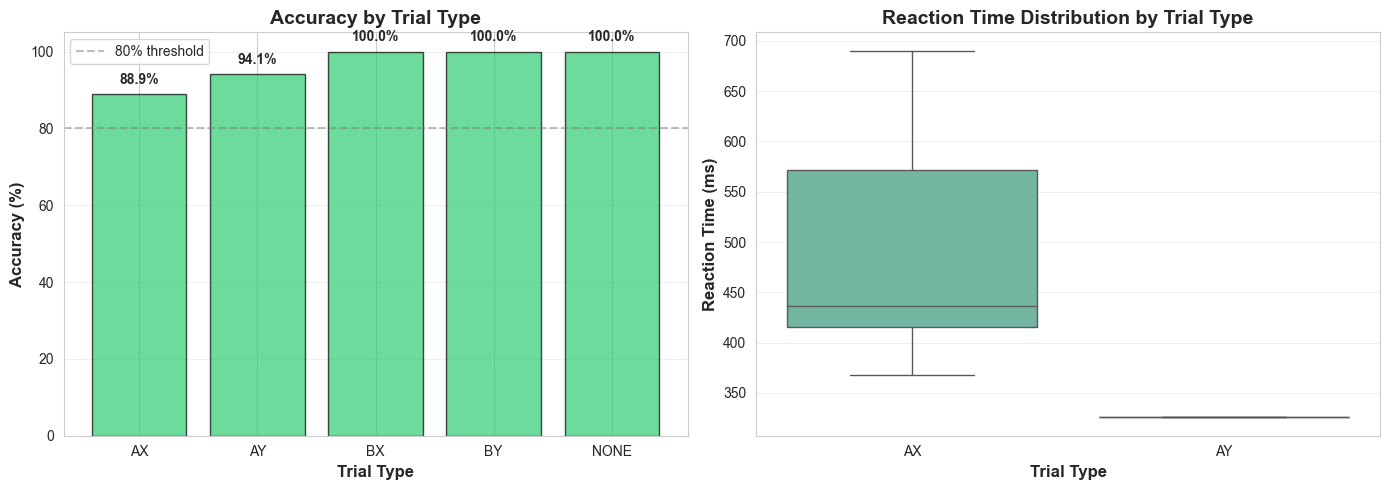

In [9]:
# Calculate performance by trial type
if files:
    # Group by trial type
    trial_type_stats = df_trials.groupby('trial_type').agg({
        'trial_index': 'count',
        'response': 'sum',
        'correct': 'sum',
        'reaction_time_ms': ['mean', 'std']
    }).round(2)
    
    trial_type_stats.columns = ['Count', 'Responses', 'Correct', 'Mean RT', 'RT Std']
    trial_type_stats['Accuracy %'] = (trial_type_stats['Correct'] / trial_type_stats['Count'] * 100).round(1)
    trial_type_stats['Response Rate %'] = (trial_type_stats['Responses'] / trial_type_stats['Count'] * 100).round(1)
    
    print("\n📊 Performance by Trial Type")
    print("=" * 60)
    display(trial_type_stats)
    
    # Visualize accuracy by trial type
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Accuracy bar chart
    ax1 = axes[0]
    trial_types = trial_type_stats.index
    accuracies = trial_type_stats['Accuracy %']
    colors = ['#2ecc71' if acc >= 80 else '#e74c3c' if acc < 60 else '#f39c12' for acc in accuracies]
    
    bars = ax1.bar(trial_types, accuracies, color=colors, alpha=0.7, edgecolor='black')
    ax1.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Trial Type', fontsize=12, fontweight='bold')
    ax1.set_title('Accuracy by Trial Type', fontsize=14, fontweight='bold')
    ax1.set_ylim(0, 105)
    ax1.axhline(y=80, color='gray', linestyle='--', alpha=0.5, label='80% threshold')
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 2,
                f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    
    # Reaction time by trial type
    ax2 = axes[1]
    rt_by_type = df_trials[df_trials['reaction_time_ms'].notna()]
    if len(rt_by_type) > 0:
        sns.boxplot(data=rt_by_type, x='trial_type', y='reaction_time_ms', ax=ax2, palette='Set2')
        ax2.set_ylabel('Reaction Time (ms)', fontsize=12, fontweight='bold')
        ax2.set_xlabel('Trial Type', fontsize=12, fontweight='bold')
        ax2.set_title('Reaction Time Distribution by Trial Type', fontsize=14, fontweight='bold')
        ax2.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

### 2.3 Reaction Time Analysis

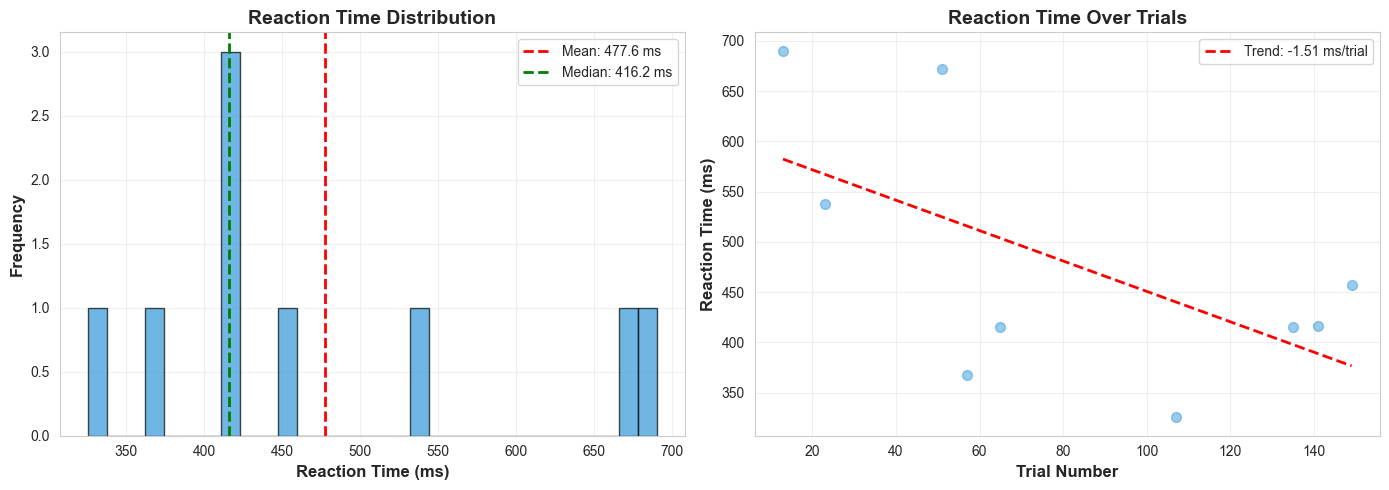


✓ RT stable over time - consistent performance


In [10]:
# Reaction time distribution and trends
if files and len(rt_data) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # RT histogram
    ax1 = axes[0]
    ax1.hist(rt_data, bins=30, color='#3498db', alpha=0.7, edgecolor='black')
    ax1.axvline(mean_rt, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_rt:.1f} ms')
    ax1.axvline(median_rt, color='green', linestyle='--', linewidth=2, label=f'Median: {median_rt:.1f} ms')
    ax1.set_xlabel('Reaction Time (ms)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Frequency', fontsize=12, fontweight='bold')
    ax1.set_title('Reaction Time Distribution', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    # RT over time (check for fatigue/learning)
    ax2 = axes[1]
    rt_trials = df_trials[df_trials['reaction_time_ms'].notna()].copy()
    ax2.scatter(rt_trials['trial_index'], rt_trials['reaction_time_ms'], 
               alpha=0.5, color='#3498db', s=50)
    
    # Add trend line
    z = np.polyfit(rt_trials['trial_index'], rt_trials['reaction_time_ms'], 1)
    p = np.poly1d(z)
    ax2.plot(rt_trials['trial_index'], p(rt_trials['trial_index']), 
            "r--", linewidth=2, label=f'Trend: {z[0]:.2f} ms/trial')
    
    ax2.set_xlabel('Trial Number', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Reaction Time (ms)', fontsize=12, fontweight='bold')
    ax2.set_title('Reaction Time Over Trials', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Interpretation
    if z[0] > 5:
        print("\n⚠️  RT increasing over time - possible fatigue effect")
    elif z[0] < -5:
        print("\n✓ RT decreasing over time - possible practice effect")
    else:
        print("\n✓ RT stable over time - consistent performance")

### 2.4 Response Pattern Timeline

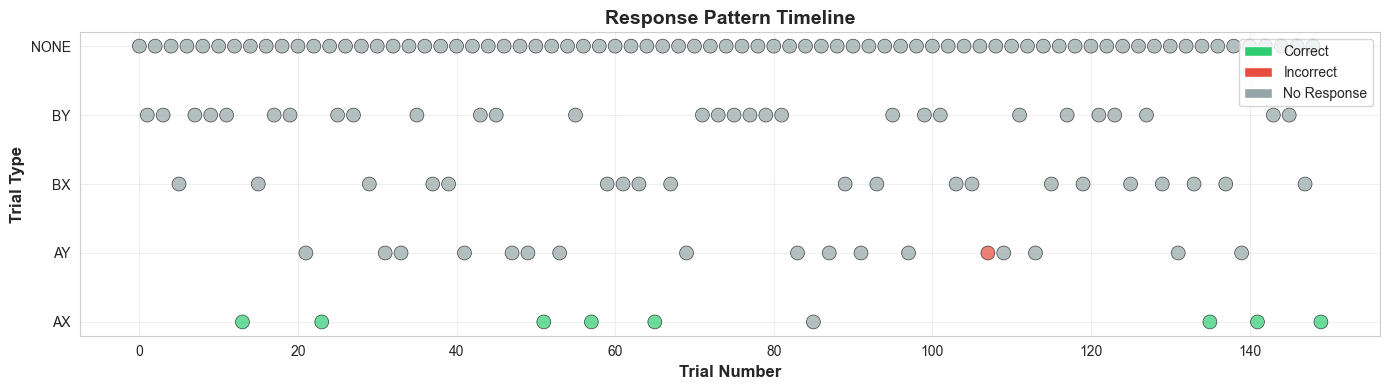

In [11]:
# Visualize response patterns over time
if files:
    fig, ax = plt.subplots(figsize=(14, 4))
    
    # Color code by outcome
    colors = []
    for _, row in df_trials.iterrows():
        if row['response'] == 0:
            colors.append('#95a5a6')  # Gray for no response
        elif row['correct'] == 1:
            colors.append('#2ecc71')  # Green for correct
        else:
            colors.append('#e74c3c')  # Red for incorrect
    
    ax.scatter(df_trials['trial_index'], df_trials['trial_type'].astype('category').cat.codes,
              c=colors, s=100, alpha=0.7, edgecolors='black', linewidth=0.5)
    
    ax.set_xlabel('Trial Number', fontsize=12, fontweight='bold')
    ax.set_ylabel('Trial Type', fontsize=12, fontweight='bold')
    ax.set_yticks(range(len(df_trials['trial_type'].unique())))
    ax.set_yticklabels(sorted(df_trials['trial_type'].unique()))
    ax.set_title('Response Pattern Timeline', fontsize=14, fontweight='bold')
    ax.grid(alpha=0.3)
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#2ecc71', label='Correct'),
        Patch(facecolor='#e74c3c', label='Incorrect'),
        Patch(facecolor='#95a5a6', label='No Response')
    ]
    ax.legend(handles=legend_elements, loc='upper right')
    
    plt.tight_layout()
    plt.show()

## 3. Webcam Tracking Analysis

This section analyzes attention-related metrics from webcam tracking (if enabled).

### 3.1 Session Summary

In [12]:
# Display tracking session summary
if files and df_session is not None:
    print("\n👁️  Webcam Tracking Session Summary")
    print("=" * 60)
    
    session_summary = pd.DataFrame({
        'Metric': [
            'Total Blinks',
            'Overall Blink Rate (blinks/sec)',
            'Total Frames Tracked',
            'Mean Head Stability',
            'Engagement Score (0-1)',
            'Fatigue Indicator',
            'Session Duration (sec)'
        ],
        'Value': [
            df_session['total_blinks'].values[0],
            f"{df_session['overall_blink_rate'].values[0]:.3f}",
            df_session['total_frames_tracked'].values[0],
            f"{df_session['mean_head_stability'].values[0]:.6f}",
            f"{df_session['engagement_score'].values[0]:.3f}",
            f"{df_session['fatigue_indicator'].values[0]:.3f}",
            f"{df_session['session_duration_seconds'].values[0]:.1f}"
        ]
    })
    
    display(session_summary)
    
    # Interpretation
    engagement = df_session['engagement_score'].values[0]
    fatigue = df_session['fatigue_indicator'].values[0]
    
    print("\n💡 Interpretation:")
    if engagement > 0.95:
        print("  ✓ High engagement - participant maintained good attention")
    elif engagement > 0.85:
        print("  ⚠️  Moderate engagement - some head movement detected")
    else:
        print("  ❌ Low engagement - significant head movement or looking away")
    
    if fatigue > 0.2:
        print("  ⚠️  Fatigue detected - blink rate increased over session")
    elif fatigue < -0.2:
        print("  ✓ Alertness increased over session")
    else:
        print("  ✓ Consistent alertness throughout session")
else:
    print("\n⚠️  No tracking data available. Enable webcam tracking in config.json to see these metrics.")


👁️  Webcam Tracking Session Summary


,Metric,Value
0,Total Blinks,230
1,Overall Blink Rate (blinks/sec),0.753
2,Total Frames Tracked,4782
3,Mean Head Stability,0.011596
4,Engagement Score (0-1),0.989
5,Fatigue Indicator,0.139
6,Session Duration (sec),305.5



💡 Interpretation:
  ✓ High engagement - participant maintained good attention
  ✓ Consistent alertness throughout session


### 3.2 Blink Analysis

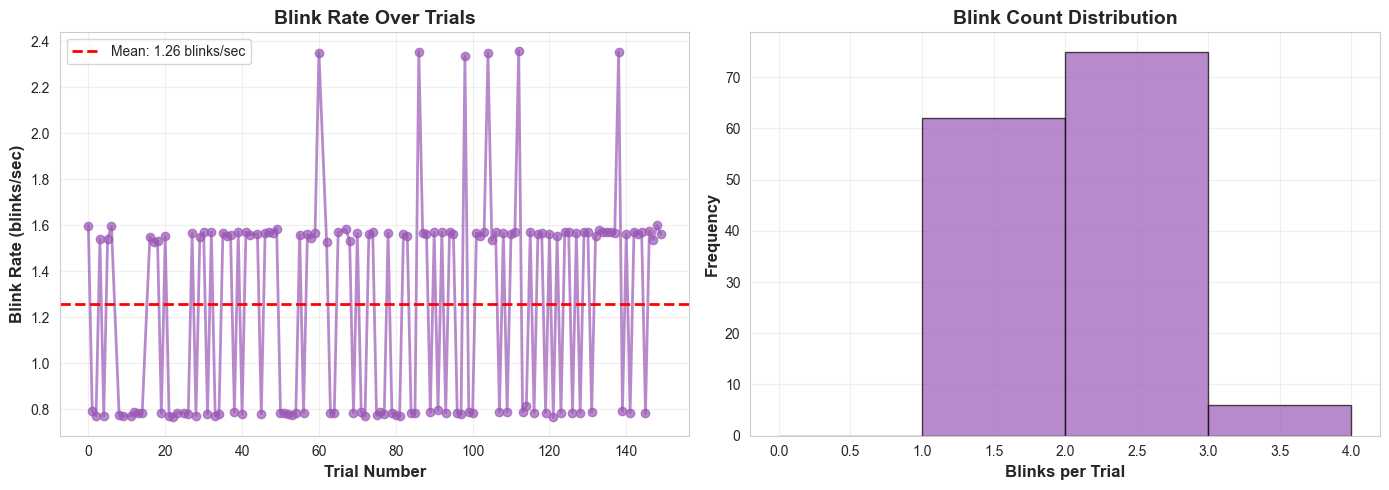


📊 Blink Rate Comparison:
  First half:  1.175 blinks/sec
  Second half: 1.338 blinks/sec
  Change:      13.8%


In [13]:
# Analyze blink patterns
if files and df_trials['blink_count'].notna().any():
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Blink rate over trials
    ax1 = axes[0]
    trials_with_tracking = df_trials[df_trials['blink_rate'].notna()].copy()
    
    ax1.plot(trials_with_tracking['trial_index'], trials_with_tracking['blink_rate'], 
            marker='o', linewidth=2, markersize=6, color='#9b59b6', alpha=0.7)
    ax1.axhline(y=trials_with_tracking['blink_rate'].mean(), 
               color='red', linestyle='--', linewidth=2, 
               label=f"Mean: {trials_with_tracking['blink_rate'].mean():.2f} blinks/sec")
    
    ax1.set_xlabel('Trial Number', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Blink Rate (blinks/sec)', fontsize=12, fontweight='bold')
    ax1.set_title('Blink Rate Over Trials', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    # Blink count distribution
    ax2 = axes[1]
    ax2.hist(trials_with_tracking['blink_count'], bins=range(0, int(trials_with_tracking['blink_count'].max())+2),
            color='#9b59b6', alpha=0.7, edgecolor='black')
    ax2.set_xlabel('Blinks per Trial', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Frequency', fontsize=12, fontweight='bold')
    ax2.set_title('Blink Count Distribution', fontsize=14, fontweight='bold')
    ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # First half vs second half comparison (fatigue check)
    midpoint = len(trials_with_tracking) // 2
    first_half_blinks = trials_with_tracking.iloc[:midpoint]['blink_rate'].mean()
    second_half_blinks = trials_with_tracking.iloc[midpoint:]['blink_rate'].mean()
    
    print(f"\n📊 Blink Rate Comparison:")
    print(f"  First half:  {first_half_blinks:.3f} blinks/sec")
    print(f"  Second half: {second_half_blinks:.3f} blinks/sec")
    print(f"  Change:      {((second_half_blinks - first_half_blinks) / first_half_blinks * 100):.1f}%")
else:
    print("\n⚠️  No blink tracking data available.")

### 3.3 Head Movement Analysis

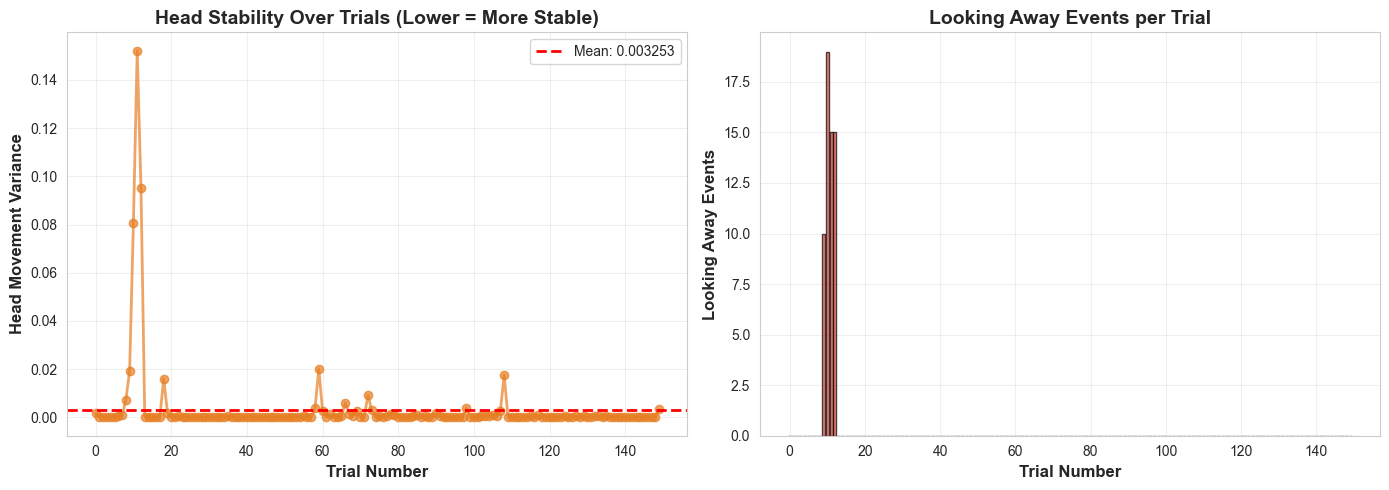

In [14]:
# Analyze head movement and stability
if files and df_trials['head_movement_variance'].notna().any():
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Head stability over trials
    ax1 = axes[0]
    trials_with_tracking = df_trials[df_trials['head_movement_variance'].notna()].copy()
    
    ax1.plot(trials_with_tracking['trial_index'], trials_with_tracking['head_movement_variance'],
            marker='o', linewidth=2, markersize=6, color='#e67e22', alpha=0.7)
    ax1.axhline(y=trials_with_tracking['head_movement_variance'].mean(),
               color='red', linestyle='--', linewidth=2,
               label=f"Mean: {trials_with_tracking['head_movement_variance'].mean():.6f}")
    
    ax1.set_xlabel('Trial Number', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Head Movement Variance', fontsize=12, fontweight='bold')
    ax1.set_title('Head Stability Over Trials (Lower = More Stable)', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    # Looking away events
    ax2 = axes[1]
    if trials_with_tracking['looking_away_count'].sum() > 0:
        ax2.bar(trials_with_tracking['trial_index'], trials_with_tracking['looking_away_count'],
               color='#e74c3c', alpha=0.7, edgecolor='black')
        ax2.set_xlabel('Trial Number', fontsize=12, fontweight='bold')
        ax2.set_ylabel('Looking Away Events', fontsize=12, fontweight='bold')
        ax2.set_title('Looking Away Events per Trial', fontsize=14, fontweight='bold')
        ax2.grid(alpha=0.3)
    else:
        ax2.text(0.5, 0.5, 'No looking away events detected\n✓ Good attention maintenance',
                ha='center', va='center', transform=ax2.transAxes,
                fontsize=14, fontweight='bold', color='#2ecc71')
        ax2.axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("\n⚠️  No head movement tracking data available.")

### 3.4 Frame-Level Tracking Visualization


📹 Frame-level tracking: 4782 frames analyzed


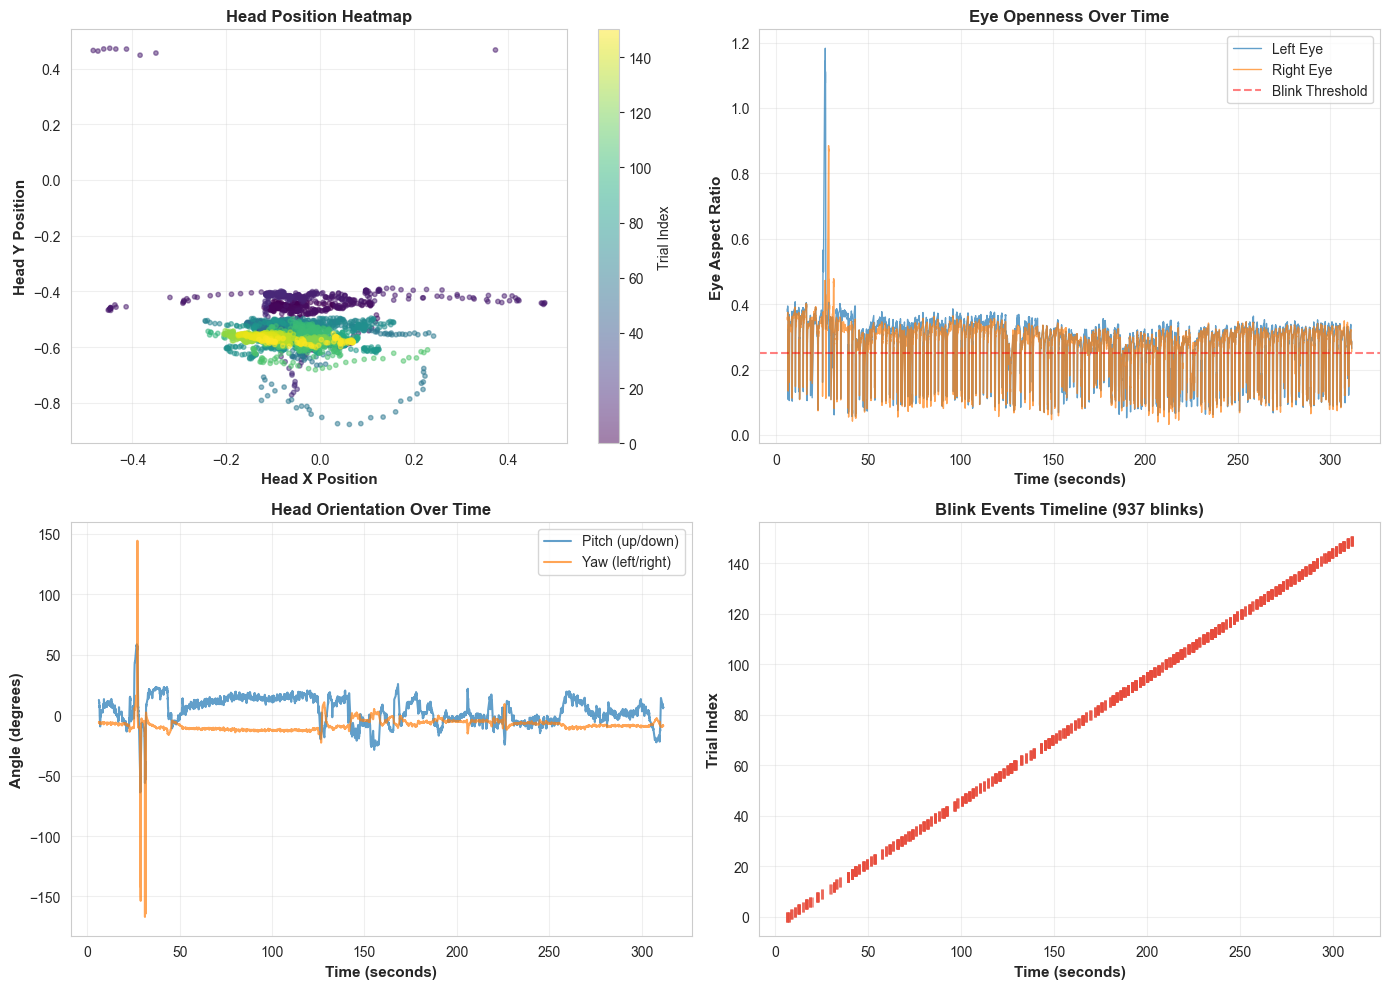

In [15]:
# Visualize frame-level tracking data
if files and df_frames is not None:
    print(f"\n📹 Frame-level tracking: {len(df_frames)} frames analyzed")
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Head position over time (X-Y scatter)
    ax1 = axes[0, 0]
    scatter = ax1.scatter(df_frames['head_x'], df_frames['head_y'], 
                         c=df_frames['trial_index'], cmap='viridis', 
                         alpha=0.5, s=10)
    ax1.set_xlabel('Head X Position', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Head Y Position', fontsize=11, fontweight='bold')
    ax1.set_title('Head Position Heatmap', fontsize=12, fontweight='bold')
    plt.colorbar(scatter, ax=ax1, label='Trial Index')
    ax1.grid(alpha=0.3)
    
    # Eye aspect ratio over time (blink detection)
    ax2 = axes[0, 1]
    ax2.plot(df_frames['timestamp'], df_frames['left_eye_aspect_ratio'], 
            label='Left Eye', alpha=0.7, linewidth=1)
    ax2.plot(df_frames['timestamp'], df_frames['right_eye_aspect_ratio'],
            label='Right Eye', alpha=0.7, linewidth=1)
    ax2.axhline(y=0.25, color='red', linestyle='--', alpha=0.5, label='Blink Threshold')
    ax2.set_xlabel('Time (seconds)', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Eye Aspect Ratio', fontsize=11, fontweight='bold')
    ax2.set_title('Eye Openness Over Time', fontsize=12, fontweight='bold')
    ax2.legend()
    ax2.grid(alpha=0.3)
    
    # Head pitch/yaw over time
    ax3 = axes[1, 0]
    ax3.plot(df_frames['timestamp'], df_frames['head_pitch'], 
            label='Pitch (up/down)', alpha=0.7, linewidth=1.5)
    ax3.plot(df_frames['timestamp'], df_frames['head_yaw'],
            label='Yaw (left/right)', alpha=0.7, linewidth=1.5)
    ax3.set_xlabel('Time (seconds)', fontsize=11, fontweight='bold')
    ax3.set_ylabel('Angle (degrees)', fontsize=11, fontweight='bold')
    ax3.set_title('Head Orientation Over Time', fontsize=12, fontweight='bold')
    ax3.legend()
    ax3.grid(alpha=0.3)
    
    # Blink events timeline
    ax4 = axes[1, 1]
    blink_frames = df_frames[df_frames['is_blinking'] == True]
    ax4.scatter(blink_frames['timestamp'], blink_frames['trial_index'],
               color='#e74c3c', s=50, alpha=0.6, marker='|', linewidths=2)
    ax4.set_xlabel('Time (seconds)', fontsize=11, fontweight='bold')
    ax4.set_ylabel('Trial Index', fontsize=11, fontweight='bold')
    ax4.set_title(f'Blink Events Timeline ({len(blink_frames)} blinks)', fontsize=12, fontweight='bold')
    ax4.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("\n⚠️  No frame-level tracking data available.")

## 4. Combined Analysis: Performance vs Tracking

### 4.1 Correlation Analysis

In [16]:
# Analyze relationship between tracking metrics and performance
if files and df_trials['blink_count'].notna().any():
    # Create subset with tracking data
    tracked_trials = df_trials[df_trials['blink_count'].notna()].copy()
    
    # Calculate correlations
    print("\n🔗 Correlation between Tracking Metrics and Performance")
    print("=" * 60)
    
    correlations = {
        'Blink Rate vs Accuracy': tracked_trials[['blink_rate', 'correct']].corr().iloc[0, 1],
        'Head Movement vs Accuracy': tracked_trials[['head_movement_variance', 'correct']].corr().iloc[0, 1],
        'Looking Away vs Accuracy': tracked_trials[['looking_away_count', 'correct']].corr().iloc[0, 1]
    }
    
    # Also check RT correlations if available
    rt_tracked = tracked_trials[tracked_trials['reaction_time_ms'].notna()]
    if len(rt_tracked) > 0:
        correlations['Blink Rate vs RT'] = rt_tracked[['blink_rate', 'reaction_time_ms']].corr().iloc[0, 1]
        correlations['Head Movement vs RT'] = rt_tracked[['head_movement_variance', 'reaction_time_ms']].corr().iloc[0, 1]
    
    corr_df = pd.DataFrame(list(correlations.items()), columns=['Relationship', 'Correlation'])
    corr_df['Correlation'] = corr_df['Correlation'].round(3)
    display(corr_df)
    
    print("\n💡 Interpretation:")
    print("  Correlation > 0.3: Moderate positive relationship")
    print("  Correlation < -0.3: Moderate negative relationship")
    print("  |Correlation| < 0.3: Weak or no relationship")
else:
    print("\n⚠️  Not enough tracking data for correlation analysis.")


🔗 Correlation between Tracking Metrics and Performance


,Relationship,Correlation
0,Blink Rate vs Accuracy,0.127
1,Head Movement vs Accuracy,0.010
2,Looking Away vs Accuracy,0.019
3,Blink Rate vs RT,-0.470
4,Head Movement vs RT,-0.388



💡 Interpretation:
  Correlation > 0.3: Moderate positive relationship
  Correlation < -0.3: Moderate negative relationship
  |Correlation| < 0.3: Weak or no relationship


### 4.2 Error Analysis with Tracking Context


❌ Error Analysis with Tracking Context


,Metric,Correct Trials,Incorrect Trials
0,Blink Rate,1.264,0.784
1,Head Movement,0.003270,0.001934
2,Looking Away Events,0.40,0.00


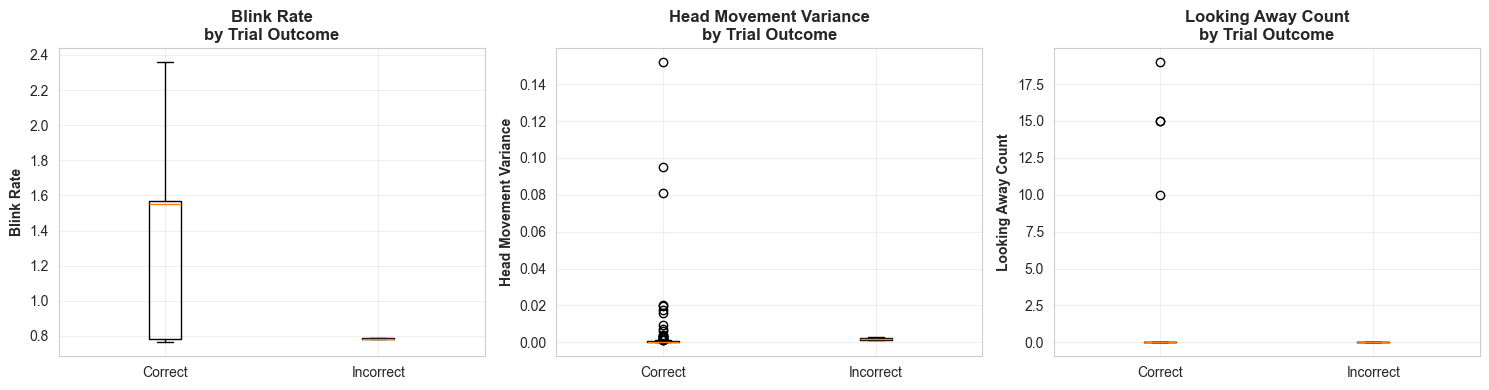

In [17]:
# Analyze errors in context of tracking data
if files and df_trials['blink_count'].notna().any():
    tracked_trials = df_trials[df_trials['blink_count'].notna()].copy()
    
    # Compare tracking metrics for correct vs incorrect trials
    correct_trials = tracked_trials[tracked_trials['correct'] == 1]
    incorrect_trials = tracked_trials[tracked_trials['correct'] == 0]
    
    if len(incorrect_trials) > 0:
        print("\n❌ Error Analysis with Tracking Context")
        print("=" * 60)
        
        comparison = pd.DataFrame({
            'Metric': ['Blink Rate', 'Head Movement', 'Looking Away Events'],
            'Correct Trials': [
                f"{correct_trials['blink_rate'].mean():.3f}",
                f"{correct_trials['head_movement_variance'].mean():.6f}",
                f"{correct_trials['looking_away_count'].mean():.2f}"
            ],
            'Incorrect Trials': [
                f"{incorrect_trials['blink_rate'].mean():.3f}",
                f"{incorrect_trials['head_movement_variance'].mean():.6f}",
                f"{incorrect_trials['looking_away_count'].mean():.2f}"
            ]
        })
        
        display(comparison)
        
        # Visualize
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))
        
        metrics = ['blink_rate', 'head_movement_variance', 'looking_away_count']
        titles = ['Blink Rate', 'Head Movement Variance', 'Looking Away Count']
        
        for idx, (metric, title) in enumerate(zip(metrics, titles)):
            ax = axes[idx]
            data_to_plot = [correct_trials[metric].dropna(), incorrect_trials[metric].dropna()]
            ax.boxplot(data_to_plot, labels=['Correct', 'Incorrect'])
            ax.set_ylabel(title, fontweight='bold')
            ax.set_title(f'{title}\nby Trial Outcome', fontweight='bold')
            ax.grid(alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    else:
        print("\n✓ No errors detected - perfect performance!")
else:
    print("\n⚠️  Not enough tracking data for error analysis.")

## 5. Trial-by-Trial Deep Dive

In [18]:
# Interactive table for detailed trial inspection
if files:
    print("\n🔍 Trial-by-Trial Data (showing first 20 trials)")
    print("=" * 80)
    
    # Select relevant columns
    display_cols = ['trial_index', 'trial_type', 'stimulus', 'response', 'correct', 'reaction_time_ms']
    
    # Add tracking columns if available
    if df_trials['blink_count'].notna().any():
        display_cols.extend(['blink_count', 'blink_rate', 'head_movement_variance', 'looking_away_count'])
    
    display(df_trials[display_cols].head(20))
    
    print("\n💡 Tip: You can filter and sort this data to investigate specific patterns.")
    print("   Example: df_trials[df_trials['correct'] == 0] shows only error trials")


🔍 Trial-by-Trial Data (showing first 20 trials)


,trial_index,trial_type,stimulus,response,correct,reaction_time_ms,blink_count,blink_rate,head_movement_variance,looking_away_count
0,0,NONE,B,0,1,NaN,2,1.599,0.001715,0
1,1,BY,Y,0,1,NaN,1,0.791,0.000248,0
2,2,NONE,B,0,1,NaN,1,0.771,0.000087,0
3,3,BY,Y,0,1,NaN,2,1.539,0.000167,0
4,4,NONE,B,0,1,NaN,1,0.771,0.000113,0
5,5,BX,X,0,1,NaN,2,1.541,0.000349,0
6,6,NONE,B,0,1,NaN,2,1.595,0.000447,0
7,7,BY,Y,0,1,NaN,0,NaN,0.000885,0
8,8,NONE,B,0,1,NaN,1,0.776,0.007062,0
9,9,BY,Y,0,1,NaN,1,0.770,0.019469,10



💡 Tip: You can filter and sort this data to investigate specific patterns.
   Example: df_trials[df_trials['correct'] == 0] shows only error trials


## 6. Export & Summary

In [19]:
# Generate final summary report
if files:
    print("\n" + "="*80)
    print("📋 FINAL SUMMARY REPORT")
    print("="*80)
    
    print(f"\n📁 Session: {files['trial_data'].name}")
    print(f"\n📊 BEHAVIORAL PERFORMANCE:")
    print(f"  • Total Trials: {total_trials}")
    print(f"  • Overall Accuracy: {overall_accuracy:.1f}%")
    print(f"  • Response Rate: {response_rate:.1f}%")
    print(f"  • Mean RT: {mean_rt:.1f} ms")
    
    if df_session is not None:
        print(f"\n👁️  ATTENTION METRICS:")
        print(f"  • Total Blinks: {df_session['total_blinks'].values[0]}")
        print(f"  • Blink Rate: {df_session['overall_blink_rate'].values[0]:.3f} blinks/sec")
        print(f"  • Engagement Score: {df_session['engagement_score'].values[0]:.3f}")
        print(f"  • Fatigue Indicator: {df_session['fatigue_indicator'].values[0]:.3f}")
    
    print(f"\n✅ Analysis complete!")
    print(f"\n💡 Next steps:")
    print(f"  • Modify cells above to explore specific patterns")
    print(f"  • Export figures using plt.savefig('filename.png')")
    print(f"  • Compare with other sessions by loading different files")


📋 FINAL SUMMARY REPORT

📁 Session: ax_cpt_results_2026-02-23T19-46-34.csv

📊 BEHAVIORAL PERFORMANCE:
  • Total Trials: 150
  • Overall Accuracy: 98.7%
  • Response Rate: 6.0%
  • Mean RT: 477.6 ms

👁️  ATTENTION METRICS:
  • Total Blinks: 230
  • Blink Rate: 0.753 blinks/sec
  • Engagement Score: 0.989
  • Fatigue Indicator: 0.139

✅ Analysis complete!

💡 Next steps:
  • Modify cells above to explore specific patterns
  • Export figures using plt.savefig('filename.png')
  • Compare with other sessions by loading different files
